# Create model
 Performs hiperparameter search and then train model with results obtained

## Load libraries 
Install & load python libraries

In [1]:
pip install tabgan==1.3.3 #9500 secs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 53.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 20.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 57.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 32.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.1/195.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
  Attempting uninstall: dask
    Found existing installation: dask 2024.2.0
    Uninstalling dask-2024.2.0:
      Successfully uninstalled dask-2024.2.0
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.2.0
    Uninstalling distributed-2024.2.0:
      Successfully uninstalled distributed-2024.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aut

In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

Matplotlib is building the font cache; this may take a moment.


In [5]:
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.memory_usage', True)

## Load data 
Load train & test data from parquet file previously saved <br>
Define limpiar_nombres_columnas & nombres_de_columnas <br>
Define input variables for model <br>
Define is do hyperparameter search or not

In [6]:
hp_search = 0 #whether search hyperparameters or run directly 

s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
df1Train = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Train/Train.parquet")
tg1Train = df1Train['target']

df1Val = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Validation/Validation.parquet")
tg1Val = df1Val['target']


In [7]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
df1Train = limpiar_nombres_columnas(df1Train)
df1Val = limpiar_nombres_columnas(df1Val)

In [8]:
#listar las columnas del dataframe

def nombres_de_columnas(dataframe):
    return dataframe.columns.tolist()

# Supongamos que tu DataFrame se llama 'df'
# Puedes ajustar el nombre según el que hayas utilizado

nombres_columnas = nombres_de_columnas(df1Train)

# Imprimir los nombres de las columnas
print(f'Nombres de columnas: {nombres_columnas}')


Nombres de columnas: ['id_branch', 'id_receiver', 'date_receiver', 'id_location', 'id_payer', 'id_sender_global', 'net_amount_receiver', 'receiver_transaction_count', 'receiver_date_first_transaction', 'receiver_date_last_transaction', 'id_country_receiver_claim', 'id_state_receiver_claim', 'id_state', 'branch_working_days', 'sender_sending_days', 'sender_days_to_last_transaction', 'id_country', 'fraud_classification', 'sender_minutes_since_last_transaction', 'branch_minutes_since_last_transaction', 'sender_days_since_last_transaction', 'branch_trans_3m', 'count_date_receiver_distinct', 'sender_state', 'branch_has_fraud', 'fecha_last_fraud_branch', 'receiver_has_fraud', 'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 'location_nro_fraud', 'sender_trans_3m', 'range_hist', 'sender_nro_fraud', 'mes', 'hour_receiver', '01_isMexico', '01_sender_branch_state', '01_var_range_hist', '01_receiver_fraud', '01_branch_fraud', '01_location_fraud', '01_sender_fraud', '01_isCashPick

In [9]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [10]:
#Load train & validation and join both for latter split

X_train = df1Train[var_input]
X_test = df1Val[var_input] 
y_train =  pd.DataFrame(df1Train['target']) 
y_test = pd.DataFrame(df1Val['target']) 

X = pd.concat([df1Train[var_input], df1Val[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 


In [11]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

0.003557576657705161

## Training

In [12]:
# Split into train (80%) and validation (20%)
# X_train: features for train, X_test: features for validation
# y_train: labels for train, y_test: labels for validation

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 88) 

In [13]:
fit_parameters = {
    #"early_stopping_rounds": 30,           # Number of rounds to stop train when there is no more improvement
    "eval_metric": 'logloss',              # Metric for evaluation
    "eval_set": [(X_test, y_test)],        # Dataset for evaluation during training
    'eval_names': ['valid'],               # Name for validation set
    #'verbose': 100,                        # Log level of output during training
}

In [14]:
# Parameters for hiperparamenter search (RandomizedSearchCV)
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50, 100, 150, 300, 400, 500, 510, 520],
    # Number of estimatores (trees) to fit

    "num_leaves": [2, 3, 4, 6, 10, 20, 25, 28, 30, 31, 32, 33, 35, 40, 45],
    # Maximun number of node leaves

    "max_depth": [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 35, 100, 125, 150, 170, 200, 250, 300, 400],
    # Maximun tree depth

    "colsample_bytree": [0.50, 0.55, 0.6, 0.65, 0.68, 0.70, 0.71, 0.80, 0.81, 0.84, 0.85, 0.86, 0.9],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [0.001, 0.002, 0.0025, 0.0026, 0.0027, 0.003, 0.004, 0.005, 0.007, 0.008, 0.009],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.1, 0.02, 0.03, 0.04, 0.07, 0.005, 0.003, 0.001],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [15]:
# Parameters for hiperparamenter search (RandomizedSearchCV) restricted to the first result obtained
param_testeoB = {
    "n_estimators": [460, 480, 400,  500, 510, 520, 530],
    # Number of estimatores (trees) to fit

    "num_leaves": [ 25, 26, 28, 30, 32, 34, 35],
    # Maximun number of node leaves

    "max_depth": [ 17, 18, 19, 20, 21, 22, 23],
    # Maximun tree depth

    "colsample_bytree": [ 0.82 ,0.83, 0.84, 0.86, 0.87],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [ 0.0025, 0.0026, 0.0027, 0.0031, 0.0033 ],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [16]:
# This parameter defines the number of hiperparameters points to be tested
n_HP_points_to_test = 100


In [17]:
def entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87):
    """
    Entrena un modelo utilizando LightGBM con búsqueda aleatoria de hiperparámetros.

    Parameters:
    - X: Características del conjunto de datos.
    - Y: Etiquetas del conjunto de datos.
    - fit_parameters: Parámetros para el entrenamiento y evaluación del modelo.
    - param_testeo: Parámetros para la búsqueda aleatoria de hiperparámetros.
    - n_HP_points_to_test: Número de combinaciones de hiperparámetros a probar (predeterminado: 100).
    - random_state: Semilla aleatoria para reproducibilidad (predeterminado: 87).

    Returns:
    - Objeto de resultados de RandomizedSearchCV.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Clean column names calling function limpiar_nombres_columnas
    X_train = limpiar_nombres_columnas(X_train)
    X_test = limpiar_nombres_columnas(X_test)

    # Create clasifier LightGBM and perform parametric search of hyperparameters
    lgbm = LGBMClassifier(random_state=random_state)
    result_trainRandom = RandomizedSearchCV(
                        estimator=lgbm, 
                        param_distributions=param_testeo, 
                        n_iter=n_HP_points_to_test,
                        scoring='f1_micro',
                        cv=3,
                        refit=True,
                        random_state=random_state,
                        verbose=True)

    # Train model using train data and parampeters
    result_trainRandom.fit(X_train, y_train.values.ravel(), **fit_parameters)

    return result_trainRandom
   


In [18]:
#If hp_search == 1 it does hyperparameter search 
if hp_search == 1:
    result = entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87)

In [19]:
if hp_search == 1:
    result.best_params_

In [20]:
# Train model with best hyperparameters found in search
if hp_search == 1:
    lgb_classifier = LGBMClassifier(**result.best_params_)

In [21]:
# Set parameters for model from result of previuos hyperparameter search
if hp_search == 0:
    best_params_ = {'subsample': 1,
     'scale_pos_weight': 0.003,
     'objective': 'binary',
     'num_leaves': 30,
     'n_estimators': 520,
     'min_child_weight': 0.0026,
     'max_depth': 20,
     'learning_rate': 0.07,
     'importance_type': 'gini',
     'colsample_bytree': 0.84,
     'boosting_type': 'gbdt'}

    lgb_classifier = LGBMClassifier(**best_params_)

In [22]:
X_train.head()

,01_branch_working_days,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
7373245,0.241489,147.0,3841.0,0,1,1,0,0,18.0,0,False,True,1.565972,False,False,False,False,True,0,0.009901,0.742857,0.241489,0.423466,0.000000,0.030137,0.052381,0.875000
9622345,0.410196,18.0,8263.0,0,10,1,9,0,17.0,0,False,True,1.002950,False,False,False,True,False,0,0.158416,0.439286,0.410196,0.072202,0.000000,0.021918,0.038095,0.708333
14154772,0.210465,1.0,4893.0,0,5,2,4,0,12.0,0,False,True,0.723164,False,False,False,True,False,0,0.306931,0.496429,0.210465,0.057762,0.000000,0.052055,0.090476,0.541667
4701686,0.204763,4.0,444.0,0,4,4,4,0,3.0,0,False,True,3.000000,False,False,False,True,False,0,0.009901,NaN,0.204763,0.541516,0.549653,NaN,NaN,0.666667
14604943,0.324669,8.0,4013.0,0,3,2,3,0,1.0,0,False,True,1.000000,False,False,False,True,False,1,0.039604,0.967857,0.324669,0.072202,0.000000,0.920548,0.000000,0.416667


In [23]:
X.head()

,01_branch_working_days,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,0.182123,13.0,5145.0,0,2,1,2,0,6.0,0,False,True,0.570136,False,False,False,True,False,0,0.178218,0.660714,0.182123,0.075812,0.538542,0.002740,0.004762,0.458333
1,0.041254,2.0,271.0,0,3,3,3,0,9.0,0,False,True,0.731785,False,False,False,True,False,0,0.019802,0.267857,0.041254,0.027798,0.000000,0.019178,0.033333,0.500000
2,0.988764,25.0,6955.0,0,2,1,1,0,14.0,0,False,False,0.549978,False,False,False,True,False,0,0.019802,0.085714,0.988764,0.032491,0.000000,0.013699,0.023810,0.708333
3,0.959584,12.0,3434.0,0,3,1,3,0,1.0,0,True,True,1.000000,False,False,False,True,False,1,0.079208,0.678571,0.959584,0.216606,0.000000,0.821918,0.000000,0.458333
4,0.350159,64.0,633.0,0,1,1,0,0,16.0,0,True,True,1.127106,False,False,False,False,True,0,0.138614,0.848214,0.350159,0.083032,0.000000,0.021918,0.038095,0.916667


In [24]:
# Fit model to data
import lightgbm as lgb
train_data  = lgb.Dataset(X_train, label = y_train)
#model = lgb.train(params, train_data, num_boost_round=5)

lgb_classifier.fit(np.array(X_train), y_train)
lbg_predictions_labels = lgb_classifier.predict(X_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 484, number of negative: 13379410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.457170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 13379894, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000036 -> initscore=-10.227143
[LightGBM] [Info] Start training from score -10.227143


# Evaluate model on train data

In [25]:
# modelo train
#data1_f_data_pred_rf= lgb_classifier.predict(X)     
#probab_rf = lgb_classifier.predict_proba(X)

#score_rf=np.delete(probab_rf, np.s_[0], axis=1) 
#Y_c=Y.copy()
#Y_c['preds_rf'] = data1_f_data_pred_rf
#Y_c['score_rf'] = score_rf

In [26]:
# Realizar predicciones con el modelo entrenado en el conjunto de entrenamiento
data1_f_data_pred_rf = lgb_classifier.predict(X)

# Obtener las probabilidades predichas para la clase positiva (clase 1) del modelo
probab_rf = lgb_classifier.predict_proba(X)

# Extraer las puntuaciones (probabilidades) asociadas con la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Crear una copia de las etiquetas verdaderas (Y) para análisis adicional
Y_c = Y.copy()
Y_c = pd.DataFrame(Y_c)

# Agregar las predicciones y las puntuaciones del modelo a las etiquetas verdaderas
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

# Los datos ahora contienen etiquetas verdaderas, predicciones y puntuaciones del modelo
# Puedes utilizar estos resultados para realizar análisis y evaluar el rendimiento del modelo.
#Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 

In [27]:
 Y_c[Y_c['target'] == True]

,target,preds_rf,score_rf
11467,True,True,0.999981
68122,True,True,0.871225
100079,True,True,0.939156
130136,True,True,0.895285
135191,True,True,0.993492
...,...,...,...
16539665,True,True,0.990758
16547659,True,True,0.856112
16573124,True,True,0.834330
16602088,True,True,0.999999


In [28]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,16724273,0
1,92,503


<Axes: xlabel='score_rf', ylabel='Count'>

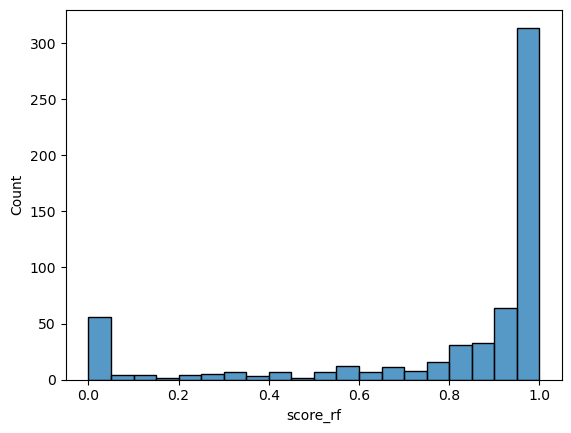

In [29]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [30]:
target_names = ['No fraude', 'Fraude']
print(classification_report(Y_c['target'], Y_c['preds_rf'], target_names=target_names))

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00  16724273
      Fraude       1.00      0.85      0.92       595

    accuracy                           1.00  16724868
   macro avg       1.00      0.92      0.96  16724868
weighted avg       1.00      1.00      1.00  16724868



In [31]:
Y_c['preds_rf'].value_counts()

preds_rf
False    16724365
True          503
Name: count, dtype: int64

In [32]:
Y_c.score_rf[Y_c['preds_rf']==True].min()

0.5009422165923999

In [33]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
#percentiles = pd.qcut(Y_c['score_rf'], q=10, duplicates='drop').astype(str)
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')

percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA .04%:
0.9949579831932773


In [34]:
DECILES_T = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])

In [35]:
DECILES_T

target,False,True
FRAUD_DECILE,,
1,16140,585
2,16720,5
3,16723,2
4,16725,0
5,16724,1
...,...,...
996,16725,0
997,16725,0
998,16725,0


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

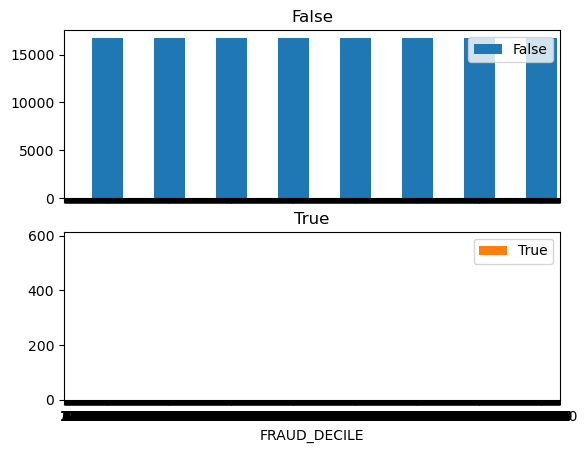

In [36]:
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

In [37]:
#saco el punto de corte del primer centil para aplicarlo al test
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.024627e-06  1.000000e+00
2             3.128149e-07  1.024534e-06
3             1.539576e-07  3.128147e-07
4             9.284925e-08  1.539511e-07
5             6.258866e-08  9.284761e-08
...                    ...           ...
996           9.862372e-14  1.121741e-13
997           8.376236e-14  9.862332e-14
998           6.742712e-14  8.376210e-14
999           4.741777e-14  6.742564e-14
1000          1.787882e-15  4.741459e-14

[1000 rows x 2 columns]

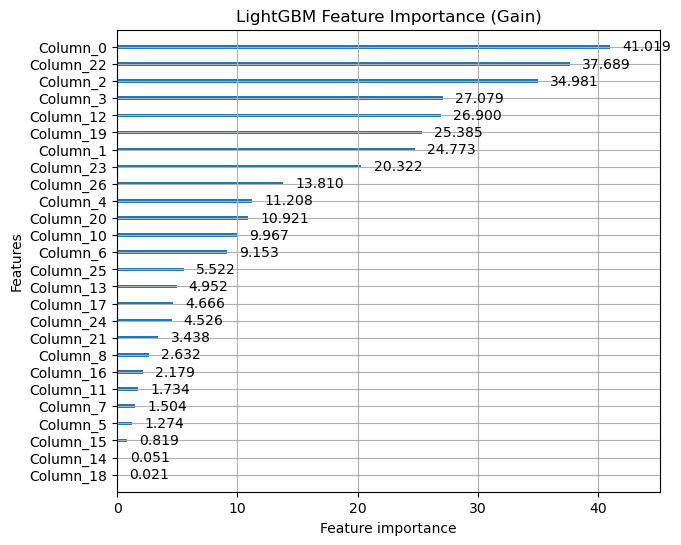

In [38]:
lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

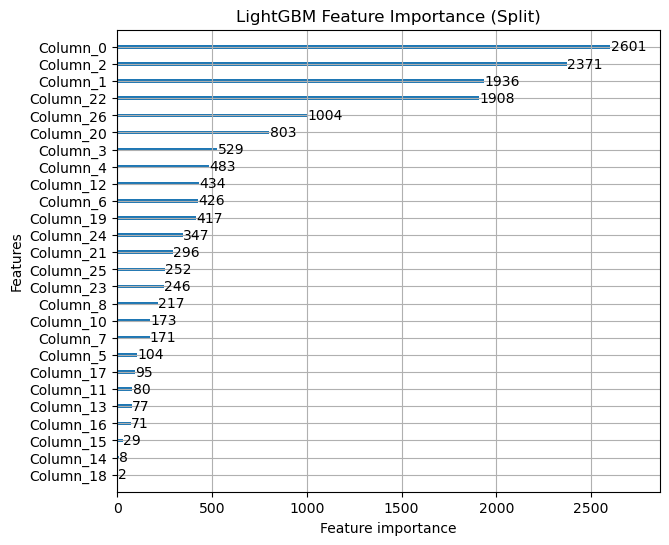

In [39]:
# Plot feature importance using Split
lgb.plot_importance(lgb_classifier, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [40]:
# Run when it has to save new model

import joblib
joblib.dump(lgb_classifier, 'ModeloFinal2.pkl')
with open("./ModeloFinal2.txt", "w") as output:
    output.write(str(var_input))


In [41]:
#Guardo los puntos de corte para recodificar el score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
#Buckets['final_score'] = 1 - (1000/Buckets['FRAUD_DECILE'])
#Buckets.to_csv ('./Buckets.csv')

In [42]:
Buckets[]

SyntaxError: invalid syntax (4165116362.py, line 1)

In [ ]:
pd.DataFrame(Buckets)

In [43]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
np.savetxt('./ModeloFinal2Imp.txt', lgb_classifier.booster_.feature_importance(importance_type='gain'),fmt='%f')

## TEST ##

In [44]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"

tes = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Test/Test.parquet")


In [45]:
## TARGETS de TESTE0
#target 1
#tgt = tes['target']

In [46]:
##lista de variables de input
X = tes[var_input]
Y = tes['target'] 


In [47]:
testeo = tes

In [48]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo = limpiar_nombres_columnas(testeo)

In [49]:
testeo = testeo
 
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

Dataset Length:  9754043
Dataset Shape:  (9754043, 81)


In [50]:
testeo['target'].value_counts(dropna=False)

target
False    9753879
True         164
Name: count, dtype: int64

In [51]:
## Variables of model
X_TESTEO = tes[var_input]
X_TESTEO

,01_branch_working_days,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,0.19520375649840684962,1.00000000000000000000,10319,0,4,3,1,0,10.00000000000000000000,0,False,True,0.19396551724137930939,False,False,False,True,False,0,0.00990099009900990111,1.00000000000000000000,0.19520375649840684962,0.03249097472924187407,0.00034722222222222224,0.00000000000000000000,0.00000000000000000000,0.75000000000000000000
1,0.60405835988596345842,8.00000000000000000000,4960,0,2,2,2,0,1.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,True,False,0,0.17821782178217820958,NaN,0.60405835988596345842,0.12635379061371840304,0.00000000000000000000,NaN,NaN,0.37500000000000000000
2,0.09676337414053329256,2.00000000000000000000,2883,0,11,4,6,0,1.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,True,False,1,0.00000000000000000000,0.73750000000000004441,0.09676337414053329256,0.02166064981949458387,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.50000000000000000000
3,0.20207949018950194242,38.00000000000000000000,2832,0,2,1,2,0,7.00000000000000000000,0,True,True,0.92368591630682039817,False,False,False,True,False,0,0.20792079207920791117,0.97857142857142853654,0.20207949018950194242,0.43321299638989169134,0.00000000000000000000,0.03835616438356164587,0.06666666666666666574,0.54166666666666662966
4,0.21901727318463859451,1.00000000000000000000,6574,0,10,3,7,0,2.00000000000000000000,0,False,True,0.65870307167235497836,False,False,False,False,True,0,0.09900990099009901457,0.96071428571428574283,0.21901727318463859451,0.06967509025270758605,0.00000000000000000000,0.01917808219178082293,0.03333333333333333287,0.75000000000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9754038,0.31661915143384200544,19.00000000000000000000,2130,0,3,1,3,0,5.00000000000000000000,0,False,True,0.36406799589473792800,False,False,False,True,False,0,0.12871287128712871617,1.00000000000000000000,0.31661915143384200544,0.05276173285198556412,0.00000000000000000000,0.06575342465753424015,0.11428571428571428215,0.54166666666666662966
9754039,1.00000000000000000000,2.00000000000000000000,2088,0,4,4,4,0,10.00000000000000000000,0,False,True,0.16666666666666665741,False,False,False,True,False,0,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.01805054151624548714,0.00069444444444444447,0.00000000000000000000,0.00000000000000000000,0.45833333333333331483
9754040,0.60036894180781485986,3.00000000000000000000,2694,0,6,3,3,0,9.00000000000000000000,0,True,True,0.45825406301799892494,False,False,False,False,True,0,0.00000000000000000000,1.00000000000000000000,0.60036894180781485986,0.09025270758122744263,0.00104166666666666665,0.00000000000000000000,0.00000000000000000000,0.58333333333333337034
9754041,0.20593660908938454801,6.00000000000000000000,3844,0,3,2,2,0,1.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,False,True,0,0.00000000000000000000,NaN,0.20593660908938454801,0.90252707581227431533,0.00000000000000000000,NaN,NaN,0.62500000000000000000


In [52]:

# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO = pd.DataFrame(testeo['target'])

# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO)

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = lgb_classifier.predict_proba(X_TESTEO)

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [53]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_TESTEO_c = Y_TESTEO.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_TESTEO_c['score_rf'] = score_rf

Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte

In [54]:
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['preds_rf']))

,0,1
0,9753877,2
1,146,18


In [55]:
Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['pred_corte']))

,0,1
0,9724102,29777
1,43,121


In [56]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=10, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}

percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .04%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA .04%:
0.9878048780487805


In [57]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target'])

In [58]:
DECILES

target,False,True
FRAUD_DECILE,,
1,975244,161
2,975403,1
3,975404,0
4,975404,0
5,975402,2
6,975405,0
7,975404,0
8,975404,0
9,975404,0


In [59]:
Y_TESTEO_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': ['min', 'max']}) 

score_rf                       
                                min                    max
FRAUD_DECILE                                              
1            0.00000000034405267736 0.99999985756209086585
2            0.00000000009890710754 0.00000000034405238372
3            0.00000000004496326904 0.00000000009890706880
4            0.00000000002442841312 0.00000000004496325904
5            0.00000000001442037547 0.00000000002442841134
6            0.00000000000881859633 0.00000000001442037317
7            0.00000000000536533050 0.00000000000881859250
8            0.00000000000307214113 0.00000000000536531954
9            0.00000000000144731546 0.00000000000307213961
10           0.00000000000000230945 0.00000000000144731416

array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

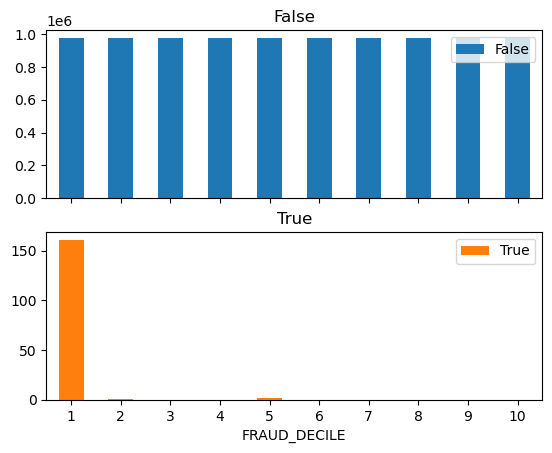

In [60]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)